**Al principio de cada archivo, están las librerías que vamos a utilizar.**

In [28]:
pip install numpy-financial

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy_financial as npf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.close("all")

**Ejemplos prácticos**

1. Aplicando una tasa de 8% efectivo anual, calcular el VAN de una operación de inversión con las siguientes características: Desembolso de 1.100.000 €. Siendo las recuperaciones de 200.000 € transcurrido un trimestre, 300.000 € transcurridos dos trimestres, 400.000 € transcurridos un trimestre más, y 500.000 transcurrido cuatro trimestres más. La duración total de la operación es de dos años.

In [3]:
cf = [-1100000, 200000, 0, 300000, 400000, 0, 0, 0, 500000] #Los periodos sin retorno de inversión se deben valorar a 0
i = 0.08
m = 4
i4 = (1+i)**(1/m)-1

VAN = npf.npv(rate = i4, values = cf)
print("{:,.2f} €".format(VAN))

178,402.55 €


2. Aplicando una tasa de 10% efectivo anual, calcular el VAN de una operación de inversión cuyo desembolso es de 70.000 € y consta de 8 recuperaciones semestrales de 12.000 € cada una. En este caso, dado que la renta es constate podemos aplicar tanto la fórmula de VNA o VA, vamos a verlo aplicado.

In [4]:
#Fórmula VNA

cf = [-70000, 12000, 12000, 12000, 12000, 12000, 12000, 12000, 12000]
i = 0.10
m = 2
i2 = (1+i)**(1/m)-1 # i2 es el tanto semestral efectivo

VAN = npf.npv(rate = i2, values = cf)
print("{:,.2f} €".format(VAN))

#Fórmula VA

pago = 70000
pmt = 12000
n = 8

VA = npf.pv(rate = i2, nper = n, pmt=-pmt, fv=0, when='end')-pago #tenemos que sacar fuera el pago inicial
print("{:,.2f} €".format(VA))


7,933.38 €
7,933.38 €


3. Ejemplo de Cálculo VAN con tasas diferentes.

Imaginemos que tenemos un proyecto, en que tendremos que realizar un desembolso inicial de 7.000 €, posteriormente nos va a generar unos flujos de caja de 1.000 euros, que irán aumentando 200 euros cada año, hasta llegar al sexto. Igualmente, el primer flujo de caja tendrá una tasa de descuento de 2% que se irá incrementando hasta llegar al 7% en el último año. Queremos conocer el VAN de esta operación para saber si es viable o no.

In [5]:
#En primer lugar, pensemos que los tipos de interés se corresponden con la ETTI (Estructura Temporal de los Tipos de Interés),
# es decir, que los tipos van cambiando y el segundo flujo de caja estará descontado al 2% dos años, sin tener en cuenta el tipo del primer año.

cf = [-7000]+ list(range(1000, 2200, 200))
cf = np.array(cf)

print("Flujos de caja: {}".format(cf))

rates = np.arange(0.01,0.075,0.01)
factores = rates + 1
print("Tasas de descuento: {}".format(rates))

n = np.arange(0,7,1)
print("Periodos: {}".format(n))


VAN = (cf/factores**n).sum()
print("VAN usando la ETTI: {:,.2f}".format(VAN))

Flujos de caja: [-7000  1000  1200  1400  1600  1800  2000]
Tasas de descuento: [0.01 0.02 0.03 0.04 0.05 0.06 0.07]
Periodos: [0 1 2 3 4 5 6]
VAN usando la ETTI: 350.18


Sin embargo, podemos considerar que el tipo de interés no cambia, y que el primer año siempre será la misma tasa, el segundo año la misma, teniendo que tener en cuenta la primera, y así sucesivamente.

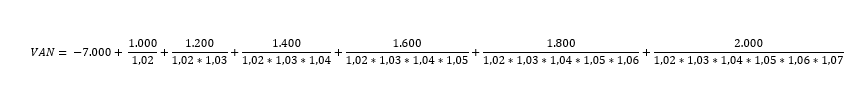

In [6]:
#Segunda opción:

cf = [-7000]
b = list(range(1000, 2200, 200))
cf1 = cf + b
cf = np.array(cf1)


rate = np.arange(0.01,0.075,0.01)
rate = rate + 1
rate[0]= 1

a=1
rate1 = []
for i in rate:
    a = a*i
    rate1.append(a)

rate1 = np.array(rate1)

VAN = (cf/rate1).sum()
print("{:,.2f} €".format(VAN)) 

print(rate)
print(rate1)

815.72 €
[1.   1.02 1.03 1.04 1.05 1.06 1.07]
[1.         1.02       1.0506     1.092624   1.1472552  1.21609051
 1.30121685]


In [7]:
cf = [-7000]
b = list(range(1000, 2200, 200))
cf1 = cf + b
cf = np.array(cf1)
print("Flujos de caja: {}".format(cf))

#lista de tipos de interés entre 1% y 6,5% con incrementos del 1%
rates = np.append([],np.arange(0.01,0.075,0.01))
factores = rates + 1
print('Factores (1+r):', factores)

factoresMult=[] # lista formada por los fm (factores multiplicados)
fm=1            # los fm (factores multiplicados) se inicializan en 1
for f in factores:
    fm*=f
    factoresMult.append(fm)
print('factoresMult=',factoresMult)

VAN = (cf/factoresMult).sum()
print('VAN:',VAN)

Flujos de caja: [-7000  1000  1200  1400  1600  1800  2000]
Factores (1+r): [1.01 1.02 1.03 1.04 1.05 1.06 1.07]
factoresMult= [1.01, 1.0302, 1.061106, 1.1035502400000001, 1.158727752, 1.22825141712, 1.3142290163184]
VAN: 807.6480765075753


Lo ideal es crear una función que nos permita calcularlo en ambos casos.

In [8]:
cf = np.array([-7000, 1000, 1200, 1400, 1600, 1800, 2000])
rate = np.array([1, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07])
n = [0, 1, 2, 3, 4, 5, 6]

def Calculo_Van(values, rate, n=None):
    if not n:
        a = 1
        rate1 = []
        for i in rate:
            a = a*i
            rate1.append(a)
            
        VAN = (values/rate1).sum()
        return VAN
    
    else:
        VAN = (values/(rate**n)).sum()
        return VAN
    
print(Calculo_Van(values=cf, rate=rate, n=n))    
print(Calculo_Van(values=cf, rate=rate))

350.1752684214696
815.7245572726517


4. Calcular la TIR de una operación de inversión con las siguientes características: Desembolso de 100.000 €. Siendo las recuperaciones de 10.000 € mensuales durante un año.

Dado que es una renta constante podemos utilizar también dos métodos, TIR (IRR) o mediante TASA (RATE)

In [9]:
#Métdodo TIR(IRR)

cf = [-100000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]

TIR = npf.irr(cf)
print(TIR)

#Método TASA(RATE)

n = 12
pmt = 10000
va = 100000

TASA = npf.rate(nper=n, pmt=pmt, pv=-va, fv=0, when='end')
print(TASA)

0.029228540769133504
0.029228540769158345


5. Calcular la TIR de una operación de inversión con las siguientes características: Desembolso de 100.000 €. Siendo las recuperaciones de 10.000 € mensuales durante un año, salvo el 3º mes que no se recupera nada y el mes 9º donde se perciben 20.000 €.


In [10]:
cf = [-100000, 10000, 10000, 0, 10000, 10000, 10000, 10000, 10000, 20000, 10000, 10000, 10000]
m = 12 # frecuencia

r12 = npf.irr(cf)     #r12 es la TIR mensual
print('Rentabilidad mensual:{}% tanto efectivo mensual'.format(r12*100))
r = (1+r12)**m-1
print('TIR = {}% tanto efectivo anual'.format(r*100))

Rentabilidad mensual:2.6973355461856086% tanto efectivo mensual
TIR = 37.62905031900152% tanto efectivo anual


6.**TIR MÚLTIPLE** En raras ocasiones, en las que tenemos un proyecto en el que los flujos de caja son positivos y negativos podemos encontrarnos que tenemos varios puntos en el que nuestro VAN es cero y por tanto, múltiples TIR

Veamos un ejemplo

In [11]:
cf = [-1200, 700, 700, 700, 700, 700, -700, -700, -700, -700, -700, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1300]
r = np.arange(0,1.05,0.00001)  


objetivo = 0                       
tolerancia1 = 0.001
tolerancia2 = -0.008

VAN = []

for i in r:
    a= npf.npv(rate=i, values=cf)
    VAN.append(a)
    diff = a - objetivo
    if diff < tolerancia1 and diff > tolerancia2:
        print(round(a,3),i)

-0.005 0.01626
-0.001 0.10061
-0.008 0.36125


Podemos ver, que este proyecto tiene tres puntos en los que su VAN es prácticamente cero, que corresponde a TIR = 1,62%, TIR = 10,06% y TIR = 36,12%.

Podemos ver esta gráfica

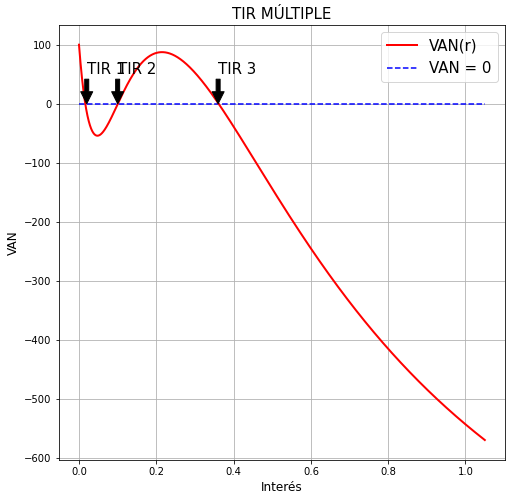

In [12]:
plt.figure(figsize = (8, 8))

plt.plot(r, VAN, color = "red", linewidth = 2, linestyle='-', label = "VAN(r)")
plt.grid()
plt.hlines(y=0, xmin = r[0], xmax=r[-1], linestyle="dashed", color="blue", label="VAN = 0")
plt.title("TIR MÚLTIPLE", fontsize=15)
plt.xlabel("Interés", fontsize=12)
plt.ylabel("VAN", fontsize=12)
plt.annotate("TIR 1", xy = (0.020, 0), xytext=(0.020, 50), arrowprops = {'color':'black'}, fontsize=15)
plt.annotate("TIR 2", xy = (0.100, 0), xytext=(0.100, 50), arrowprops = {'color':'black'}, fontsize=15)
plt.annotate("TIR 3", xy = (0.360, 0), xytext=(0.360, 50), arrowprops = {'color':'black'}, fontsize=15)
plt.legend(loc="best", fontsize=15)
plt.show()

Otra forma de realizar el cálculo, con mayor precisión.

In [13]:
from numpy_financial import npv
from numpy import arange



def TIR(cf,k_inicial=0,k_final=1):
    a=npv(k_inicial,cf)
    b=npv(k_final,cf)
    if a==0:
        return k_inicial
    elif b==0:
        return k_final
    elif a*b>0:  #Si el producto es positivo es que ambos VAN tienen el mismo signo,o los 2 positivos o los 2 neg.
        return "En el rango considerado no se corta el eje" #al ser los dos VAN del mismo signo no hay corte
    else:
        while True:
            k_medio=(k_inicial+k_final)/2
            m=npv(k_medio,cf)              # m es el VAN para el k_medio
            if abs(m)<1e-12:               # si el valor absoluto de m es menor que el error admitido (tolerancia)
                break                      # paramos el bucle y luego retornamos el k_medio 
            else:
                if a*m<0:                  # si el VAN de la izquierda y el del medio tienen distinto signo
                    k_final=k_medio
                elif b*m<0:                # si el VAN de la derecha y el del medio tienen el mismo signo
                    k_inicial=k_medio
        return k_medio



cf = [-1200, 700, 700, 700, 700, 700, -700, -700, -700, -700, -700, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1300]
r = arange(0,.4,0.001)
tasaAnterior=0  # para detectar el cambio de signo en la tasa de descuento necesitamos recordar la tasa anterior
contador=1      # vamos contando el número de cortes con el eje

for i in r:
   
    if npv(tasaAnterior,cf)*npv(i,cf)<0:      # si se produce un cambio de signo en el VAN
        # pedimos a la función TIR que calcule el corte entre la tasaAnterior e i
        miTIR = TIR(cf,tasaAnterior,i)
        print('TIR'+str(contador)+' =',miTIR,'\tVAN(TIR'+str(contador)+') =',npv(miTIR,cf)) 
        
    contador+=1
    tasaAnterior=i                            # este i es ahora la tasaAnterior


TIR18 = 0.016258725121618686 	VAN(TIR18) = 9.094947017729282e-13
TIR102 = 0.10061094102965763 	VAN(TIR102) = 7.958078640513122e-13
TIR363 = 0.36124183951893607 	VAN(TIR363) = 4.711786516509164e-13


En principio es bastante raro encontrar casos de TIR múltiple, ya que carece de sentido financiero

Una alternativa es calcular TIR modificada, para ello, lo que debemos estimar es una tasa de financiación, y una tasa de reinversión, que no siempre son fáciles de determinar. Para nuestro ejemplo hemos utilizado una tasa de financiación 8% y una tasa de reinversión de 10%


In [14]:
cf = [-1200, 700, 700, 700, 700, 700, -700, -700, -700, -700, -700, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1300]

npf.mirr(values=cf, finance_rate=0.08, reinvest_rate=0.10)

0.09528522181235122

Veamos el desarrollo de esta función

In [15]:
#El primer paso es dividir los flujos de caja en positivos y negativos:
cf = [-1200, 700, 700, 700, 700, 700, -700, -700, -700, -700, -700, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1300]
n=20
positivos = []
negativos = []

for i in cf:
    if i > 0:
        positivos.append(i)
        negativos.append(0)
    else:
        negativos.append(i)
        positivos.append(0)

        
#En segundo lugar, actualizamos los flujos negativos al momento t(0)

i = 0.08
r = 0.10

a = -npf.npv(rate=i, values=negativos)


#Después calculamos el valor final de nuestros flujos de caja positivos.

b = npf.npv(rate=r, values=positivos)*(1+r)**n


#Finalmente calculamos la tasa de ambos

TIRm = npf.rate(nper=n, pmt=0, pv=-a, fv=b)
print(TIRm)

0.09528522181314958
